# Annual Sea Level Anomalies
```{glue:figure} SL_MMA_annual_station
:scale: 25%
:align: right
```

In this notebook, we'll be taking a look at sea level anomalies (SLA), which can be thought of as signals that differ from the climatology (of a station or region). For these products we'll focus on yearly anomalies, and leave the monthly anomalies (for the most part) to the [inter-annual notebook](notebooks/regional_and_local/SL_anomaly_annual.ipynb). For a nice overview and animation of daily mean SLAs in the Hawaii and eastern Pacific region, see [Pacific Sea Level Monitoring](https://uhslc.soest.hawaii.edu/pacific-sea-level-monitoring/).

Download Files:
[Map](https://uhslc.soest.hawaii.edu/jfiedler/SeaLevelIndicators/output/Hawaii_Region_Output/1.2_2_SL_anomaly_annual_map_decadal.png) |
[Time Series Plot](https://uhslc.soest.hawaii.edu/jfiedler/SeaLevelIndicators/output/Hawaii_Region_Output/1.2_SL_MMA_annual.png)

## Setup

As with previous sections, we first need to import the necessary libraries, establish our input/output directories, and set up some basic plotting rules. We'll do this by running another notebook called "setup" and "plotting functions," and then we'll set our data and output paths. If you have not run the datawrangling notebook, you will need to do this before proceeding here.


In [1]:
%run ../setup.ipynb
from plotting_functions import plot_map, plot_zebra_frame

# check to make sure that data_dir/rsl_daily_hawaii.nc exists, if not, make warning to run datawrangling notebook
if not (data_dir / 'rsl_daily_hawaii.nc').exists():
    print('rsl_daily_hawaii.nc not found in data directory. Please run the data wrangling notebook first')
else:
    print('rsl_daily_hawaii.nc found in data directory. Proceed.')

# Set up parallel computing with dask
from dask.distributed import Client

#ensure any existing client is closed before creating a new one
try:
    client.close()
except:
    pass
client = Client()
client

Using custom paths from config_env.py
Data directory: /Users/jfiedler/Documents/SL_Hawaii_data/data
Output directory: /Users/jfiedler/Library/CloudStorage/GoogleDrive-jfiedler@hawaii.edu/Shared drives/PI Indicators 2025/SL Indicators/Hawaii_Region_Output
rsl_daily_hawaii.nc found in data directory. Proceed.


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 5
Total threads: 10,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:56636,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:56649,Total threads: 2
Dashboard: http://127.0.0.1:56651/status,Memory: 6.40 GiB
Nanny: tcp://127.0.0.1:56639,


### Import the tide gauge data

In [2]:
#import rsl_daily
rsl_daily = xr.open_dataset(data_dir/ 'rsl_daily_hawaii.nc')

### Do some data wrangling again. 
#### 1. Check the data and drop all stations with less than 80% coverage

In [3]:
data_coverage = rsl_daily.rsl_mhhw.count(dim='time')/len(rsl_daily.time)

#drop all locations with data_coverage less than 80%
rsl_subset = rsl_daily.where(data_coverage>0.80,drop=True)
rsl_daily.close()

rsl_subset

<xarray.Dataset> Size: 1MB
Dimensions:       (station_id: 7, time: 11685)
Coordinates:
  * station_id    (station_id) <U7 196B '1617760' '1619910' ... '1611400'
  * time          (time) datetime64[ns] 93kB 1993-01-02T12:00:00 ... 2024-12-...
    latitude      (station_id) float32 28B 19.69 28.19 20.06 ... 21.31 21.94
    longitude     (station_id) float32 28B 204.9 182.7 204.2 ... 202.2 200.7
    lat           (station_id) float64 56B 19.73 28.21 20.04 ... 21.3 21.95
    lon           (station_id) float64 56B 204.9 182.6 204.2 ... 202.1 200.6
    station_name  (station_id) <U27 756B 'Hilo, Hilo Bay, Kuhio Bay' ... 'Naw...
    storm_time    (time) datetime64[ns] 93kB ...
    compat        <U12 48B 'no_conflicts'
Data variables:
    rsl_anomaly   (station_id, time) float64 654kB 0.1187 0.1158 ... 0.04415
    rsl_mhhw      (station_id, time) float64 654kB -0.2698 -0.2728 ... -0.2728
Attributes:
    units:      m
    long_name:  Sea Level Anomaly
    epoch:      1993-2012

#### 2. Now we'll remove the trend (over the entire record) from this subset of stations.

In [4]:
trend_mag, sea_level_trend, trend_rate = tsf.process_trend_with_nan(rsl_subset['rsl_anomaly'])

rsl_subset['rsl_anomaly_detrended'] = rsl_subset['rsl_anomaly'] - sea_level_trend

Processing xarray DataArray (vectorized polyfit, time in years)...


#### 3. Resample to monthly time series of anomalies.

In [5]:
# resample to monthly time series 
rsl_monthly = rsl_subset.resample(time='1MS',label='left').mean()

# get climatology (annual cycle) by grouping by month
rsl_climatology = rsl_monthly.groupby('time.month').mean('time')

# get anomalies by subtracting climatology from monthly data
rsl_anomalies = rsl_monthly.groupby('time.month') - rsl_climatology

rsl_anomalies

<xarray.Dataset> Size: 90kB
Dimensions:                (station_id: 7, time: 384)
Coordinates:
  * station_id             (station_id) <U7 196B '1617760' ... '1611400'
    latitude               (station_id) float32 28B 19.69 28.19 ... 21.31 21.94
    longitude              (station_id) float32 28B 204.9 182.7 ... 202.2 200.7
    lat                    (station_id) float64 56B 19.73 28.21 ... 21.3 21.95
    lon                    (station_id) float64 56B 204.9 182.6 ... 202.1 200.6
    station_name           (station_id) <U27 756B 'Hilo, Hilo Bay, Kuhio Bay'...
    compat                 (time) <U12 18kB 'no_conflicts' ... 'no_conflicts'
  * time                   (time) datetime64[ns] 3kB 1993-01-01 ... 2024-12-01
    month                  (time) int64 3kB 1 2 3 4 5 6 7 8 ... 6 7 8 9 10 11 12
Data variables:
    rsl_anomaly            (time, station_id) float64 22kB -0.01155 ... 0.06753
    rsl_mhhw               (time, station_id) float64 22kB -0.01155 ... 0.06753
    rsl_anomaly_detrended  (time, station_id) float64 22kB 0.04501 ... 0.01776

#### 4. Now sort the subset on "storm year" instead of calendar year for yearly means.

In [6]:
# change the index to be on storm_time instead of time
rsl_subset = rsl_subset.set_index(time='storm_time')

# rename the time dimension to storm_time
rsl_subset = rsl_subset.rename({'time':'storm_time'})

rsl_subset

<xarray.Dataset> Size: 2MB
Dimensions:                (station_id: 7, storm_time: 11685)
Coordinates:
  * station_id             (station_id) <U7 196B '1617760' ... '1611400'
  * storm_time             (storm_time) datetime64[ns] 93kB 1992-01-02T12:00:...
    latitude               (station_id) float32 28B 19.69 28.19 ... 21.31 21.94
    longitude              (station_id) float32 28B 204.9 182.7 ... 202.2 200.7
    lat                    (station_id) float64 56B 19.73 28.21 ... 21.3 21.95
    lon                    (station_id) float64 56B 204.9 182.6 ... 202.1 200.6
    station_name           (station_id) <U27 756B 'Hilo, Hilo Bay, Kuhio Bay'...
    compat                 <U12 48B 'no_conflicts'
    time_in_years          (storm_time) float64 93kB 1.993e+03 ... 2.025e+03
Data variables:
    rsl_anomaly            (station_id, storm_time) float64 654kB 0.1187 ... ...
    rsl_mhhw               (station_id, storm_time) float64 654kB -0.2698 ......
    rsl_anomaly_detrended  (station_id, storm_time) float64 654kB 0.1224 ... ...
Attributes:
    units:      m
    long_name:  Sea Level Anomaly
    epoch:      1993-2012

In [7]:
# reorder to that storm_time is monotonicly increasing
rsl_subset = rsl_subset.sortby('storm_time')

# Group by storm_year and record_id
rsl_yearly_mean = rsl_subset.groupby('storm_time.year').mean('storm_time')

# give year dimension a name
rsl_yearly_mean = rsl_yearly_mean.rename({'year':'storm_year'})

rsl_yearly_mean

<xarray.Dataset> Size: 7kB
Dimensions:                (storm_year: 33, station_id: 7)
Coordinates:
  * station_id             (station_id) <U7 196B '1617760' ... '1611400'
    latitude               (station_id) float32 28B 19.69 28.19 ... 21.31 21.94
    longitude              (station_id) float32 28B 204.9 182.7 ... 202.2 200.7
    lat                    (station_id) float64 56B 19.73 28.21 ... 21.3 21.95
    lon                    (station_id) float64 56B 204.9 182.6 ... 202.1 200.6
    station_name           (station_id) <U27 756B 'Hilo, Hilo Bay, Kuhio Bay'...
    compat                 <U12 48B 'no_conflicts'
  * storm_year             (storm_year) int64 264B 1992 1993 1994 ... 2023 2024
Data variables:
    rsl_anomaly            (storm_year, station_id) float64 2kB 0.03983 ... 0...
    rsl_mhhw               (storm_year, station_id) float64 2kB -0.3487 ... -...
    rsl_anomaly_detrended  (storm_year, station_id) float64 2kB 0.04294 ... 0...
Attributes:
    units:      m
    long_name:  Sea Level Anomaly
    epoch:      1993-2012

## Absolute Value: satellite (trend removed)

In [8]:
# open the cmems data
cmems_big = xr.open_dataset(data_dir / 'cmems_L4_SSH_0.125deg_1993_2025hawaii.nc', chunks={'latitude': 'auto', 'longitude': 'auto'}) # we'll use dask to handle the big data
cmems = cmems_big.sel(longitude=slice(180,208), latitude=slice(14.5, 30.5)) # we'll cut this down to a reasonable slice for analysis and plotting. 

In [9]:
cmems

<xarray.Dataset> Size: 3GB
Dimensions:    (time: 11646, latitude: 128, longitude: 224)
Coordinates:
  * latitude   (latitude) float32 512B 14.56 14.69 14.81 ... 30.19 30.31 30.44
  * time       (time) datetime64[ns] 93kB 1993-01-01 1993-01-02 ... 2024-11-19
  * longitude  (longitude) float32 896B 180.1 180.2 180.3 ... 207.7 207.8 207.9
Data variables:
    sla        (time, latitude, longitude) float64 3GB dask.array<chunksize=(11646, 2, 27), meta=np.ndarray>
Attributes:
    source:                    Altimetry measurements
    Conventions:               CF-1.6
    comment:                   Sea Surface Height measured by Altimetry and d...
    institution:               CLS, CNES
    contact:                   servicedesk.cmems@mercator-ocean.eu
    history:                   2024-10-23 12:55:06Z: Creation
    references:                http://marine.copernicus.eu
    title:                     DT merged all satellites Global Ocean Gridded ...
    copernicusmarine_version:  2.0.0

### Plot an area-wide map, with stations
First we'll need to make sure that our data is detrended properly in order to look at yearly anomalies.

In [10]:
# concentrating on decadal trends
# let's look at 1993-2003 and 2003-2013

trend_mag, sea_level_trend, trend_rate = tsf.process_trend_with_nan(cmems['sla'].sel(time=slice('1993','2024')),weighted=False)

Processing xarray DataArray (vectorized polyfit, time in years)...


In [11]:
trend_rate

<xarray.DataArray (latitude: 128, longitude: 224)> Size: 229kB
dask.array<truediv, shape=(128, 224), dtype=float64, chunksize=(32, 43), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 512B 14.56 14.69 14.81 ... 30.19 30.31 30.44
  * longitude  (longitude) float32 896B 180.1 180.2 180.3 ... 207.7 207.8 207.9

In [12]:
trend_rate_computed = trend_rate.compute()

Using central_longitude=180 for projection


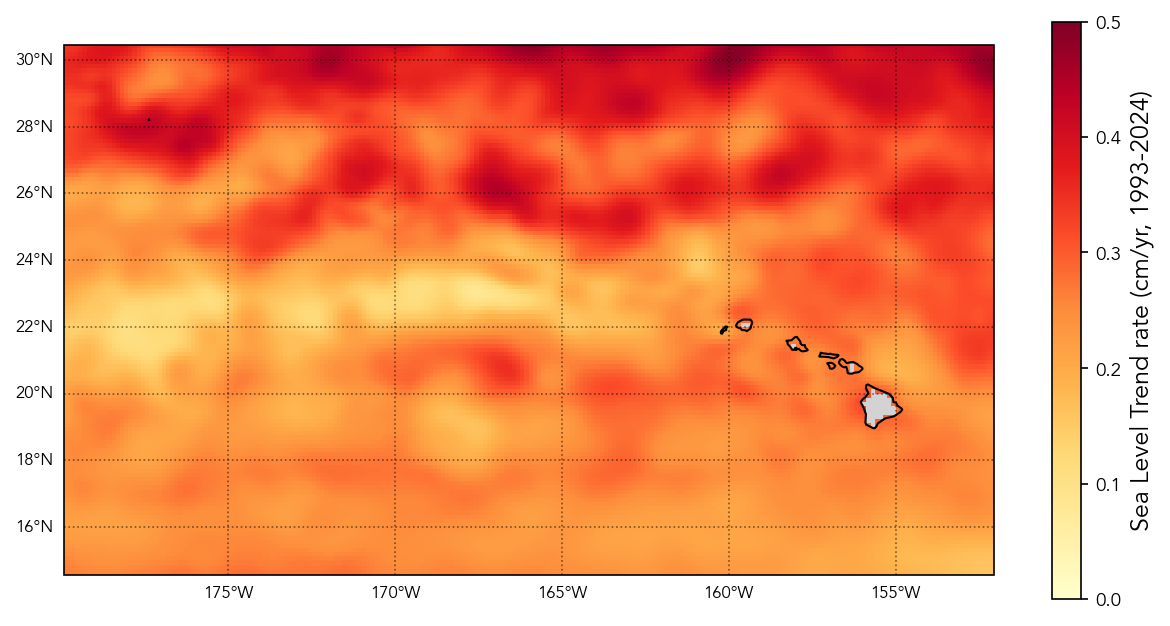

In [13]:
import warnings # import warnings to suppress warnings in cartopy
# Ignore the specific shapely warning for this cell
warnings.filterwarnings("ignore", category=RuntimeWarning, message="invalid value encountered in create_collection")


# define vmin and vmax variables
vmin = 0
vmax = 0.5
# Use float values for map extent to avoid dtype issues and ensure gridlines appear
xlims = [float(cmems.longitude.min()), float(cmems.longitude.max())]
ylims = [float(cmems.latitude.min()), float(cmems.latitude.max())]
trend_rate_cm = trend_rate_computed * 100  # convert to cm/yr

# make ax,fig
crs = ccrs.PlateCarree()
cmap = 'YlOrRd'
fig, ax, crsMap = plot_map(vmin,vmax,cmap,xlims,ylims)

trend_rate_cm.plot(ax=ax, transform=crs,
                         vmin=vmin, vmax=vmax, cmap=cmap, add_colorbar=True, 
                         cbar_kwargs={'label': 'Sea Level Trend rate (cm/yr, 1993-2024)'}
)


# save the figure
plt.savefig(output_dir / '1.2_cmems_trend_rate_1993_2024.png', dpi=300, bbox_inches='tight')


### Area-weighted average trend 

As an example, we can use the entire grid for this. That said, in reality, you'd want to pick boundaries that make more sense. You could, for example, use the EEZ.

In [14]:
startYear = '1993'
endYear = '2024'

# First, compute the area-weighted mean time series
weights = np.cos(np.deg2rad(cmems.latitude))
weights.name = "weights"
sla_weighted = cmems['sla'].sel(time=slice(startYear,endYear)).weighted(weights)
sla_regional_mean = sla_weighted.mean(dim=('latitude', 'longitude'))
trend_mag, sea_level_trend, trend_rate = tsf.process_trend_with_nan(sla_regional_mean, weighted=False)

trend_rate_computed = trend_rate.compute()
print(f'The trend rate for {startYear}-{endYear} in the entire grid is {trend_rate_computed*100:.2f} cm/yr')


Processing xarray DataArray (vectorized polyfit, time in years)...
The trend rate for 1993-2024 in the entire grid is 0.27 cm/yr


In [15]:
# concentrating on decadal trends
# let's look at 1993-2003 and 2003-2013
cmems1993_2003 = cmems.sel(time=slice('1993','2003'))

# get the overall trend (full time series)
trend_mag, sea_level_trend, trend_rate = tsf.process_trend_with_nan(cmems['sla'])

sla_weighted = cmems['sla'].weighted(weights)
sla_regional_mean = sla_weighted.mean(dim=('latitude', 'longitude'))
trend_mag_area_weighted, sea_level_trend_area_weighted, trend_rate_area_weighted = tsf.process_trend_with_nan(sla_regional_mean, weighted=False)



#remove the trend from the data
sla_detrended = cmems1993_2003['sla'] - sea_level_trend.sel(time=slice('1993','2003'))
sla_detrended_area_weighted = cmems1993_2003['sla'] - sea_level_trend_area_weighted

Processing xarray DataArray (vectorized polyfit, time in years)...
Processing xarray DataArray (vectorized polyfit, time in years)...


Let's check this for a random station in our list.

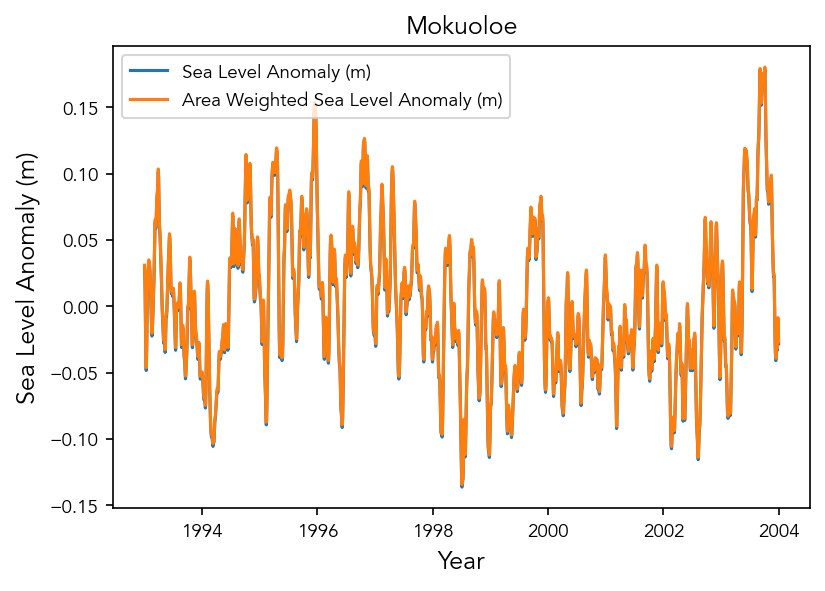

In [16]:
id = 3
lat = rsl_subset.isel(station_id=id).lat
lon = rsl_subset.isel(station_id=id).lon
sla_detrended.sel(latitude=lat, longitude=lon, method='nearest').plot(label='Sea Level Anomaly (m)')
sla_detrended_area_weighted.sel(latitude=lat, longitude=lon, method='nearest').plot(label='Area Weighted Sea Level Anomaly (m)')

# change the title to station name
plt.title(rsl_subset['station_name'].isel(station_id=id).values)
#add axis labels
plt.xlabel('Year')
plt.ylabel('Sea Level Anomaly (m)')

plt.legend()

There are slight differences between removing the grid-level trend versus the area-weighted trend in this plot. Nothing too major here.

### Create a map
Concentrating on decadal trends.

In [17]:
# concentrating on decadal trends
# let's look at 1993-2003 and 2003-2013

yr_start = [1993,2003,2013,2003]
yr_stop = [2003,2013,2023,2023]

#do storm year instead of calendar year

yr_start_str = [str(int(yr))+'-05-01' for yr in yr_start]
yr_stop_str = [str(int(yr))+'-04-30' for yr in yr_stop]

trend_mag, sea_level_trend, trend_rate = tsf.process_trend_with_nan(cmems['sla'].sel(time=slice(yr_start_str[0],yr_stop_str[-1])),weighted=False)

#remove the trend from the data
sla_detrended = cmems['sla'] - sea_level_trend

Processing xarray DataArray (vectorized polyfit, time in years)...


In [18]:
sla_detrended_computed = sla_detrended.compute()

2025-09-26 14:57:44,988 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 5.14 GiB -- Worker memory limit: 6.40 GiB
2025-09-26 14:57:45,397 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 5.37 GiB -- Worker memory limit: 6.40 GiB
2025-09-26 14:57:46,367 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 5.06 GiB -- Worker memory limit: 6.40 GiB


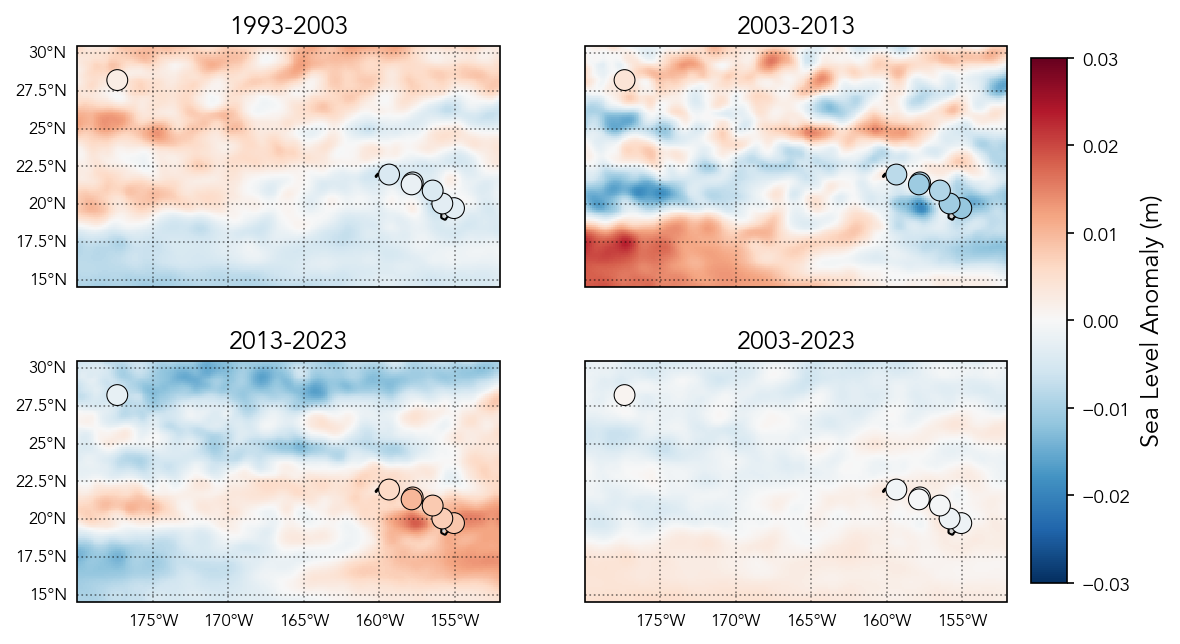

In [19]:
# make 4 subplots for each year range
from matplotlib.ticker import FuncFormatter

def pacific_all_west_formatter(x, pos=None):
    # Convert to [0, 360)
    x = (x + 360) % 360
    deg_west = (180 - x) % 360
    if deg_west == 0:
        return "180°W"
    else:
        return f"{abs(deg_west):.0f}°W"

crs_main = ccrs.PlateCarree(central_longitude=180)
crs_sub = ccrs.PlateCarree()
fig, ax = plt.subplots(2,2,figsize=(8, 5), subplot_kw={'projection': crs_main})

# Variable to hold the colorbar handle
cbar_ax = fig.add_axes([0.92, 0.15, 0.03, 0.7])  # Adjust these values to fit your layout
fig.subplots_adjust(right=0.9)  # Make space for the colorbar
 
vmin = -0.03
vmax = 0.03
# Loop through each period
for i, ax in enumerate(ax.flat):
    # Select the data for the current period and calculate the mean over time
    sla_mean = sla_detrended.sel(time=slice(yr_start_str[i],yr_stop_str[i])).mean(dim='time',skipna=True)
    # sla_mean = sla_mean - sea_level_trend.sel(time=slice(str(yr_start[i]), str(yr_stop[i]))).mean(dim='time')

    #subtract the
    
    # Plot the mean sea level anomaly
    c = sla_mean.plot(ax=ax, add_colorbar=False, transform=crs_sub, cmap='RdBu_r')
    
    # Set the title to the current period
    ax.set_title(f'{yr_start[i]}-{yr_stop[i]}')

    # Add coastlines and land  
    palette = sns.color_palette("RdBu_r", as_cmap=True)
    cmap = palette

    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.LAND, color='lightgrey')
    
    # Optionally, adjust color limits for consistency across plots
    c.set_clim(vmin,vmax)

    ax.scatter(rsl_yearly_mean['lon'], rsl_yearly_mean['lat'], transform=crs_sub, s=50,
              c='white', linewidth=0.5, edgecolor='black',zorder=10)

    ax.scatter(rsl_yearly_mean['lon'], rsl_yearly_mean['lat'], transform=crs_sub, s=100,
           c=rsl_anomalies.sel(time=slice(yr_start_str[i],yr_stop_str[i])).rsl_anomaly_detrended.mean(dim="time"), vmin=vmin, vmax=vmax, cmap=cmap,
           linewidth=0.5, edgecolor='black',zorder=10)
    
    #add grid
    gl = ax.gridlines(crs=crs_main, draw_labels=False, linestyle=':', color='black',
                      alpha=0.5,xlocs=ax.get_xticks(),ylocs=ax.get_yticks())
    gl.xformatter = FuncFormatter(pacific_all_west_formatter)
    
    if i>1:
        gl.bottom_labels = True

    if i==0:
        gl.left_labels = True

    if i==2:
        gl.left_labels = True

    #make all labels tiny
    gl.xlabel_style = {'size': 8}
    gl.ylabel_style = {'size': 8}

# Add the colorbar
cbar = fig.colorbar(c, cax=cbar_ax)
cbar.set_label('Sea Level Anomaly (m)')

glue("SL_YMA_decadal",fig,display=False)

plt.savefig(output_dir / '1.2_2_SL_anomaly_annual_map_decadal.png', dpi=300, bbox_inches='tight')


```{glue:figure} SL_YMA_decadal
:name: "SL_YMA_decadal"

Decadal (or bidecadal) mean anomalies of the Hawaiian Islands region, background trend (Storm Years 1993-2023) removed. Note that the sea level is plotted in units of m. The mean anomaly is near zero when using the full timeseries and grid-level trends (i.e. no area-weighted averaging). Mean monthly anomalies at the stations are plotted as well, showing similar-ish patterns.
```

## Time Series Plots
Now we'll look at monthly and yearly anomalies at the tide stations through time. We'll also plot ENSO signals on the same plot, to get a visual feel for any ENSO-driven anomalous effects on sea level.

In [20]:
def plot_TG_rsl_anomaly_annual(rid, fig, ax, rsl_yearly_mean, rsl_subset, rsl_anomalies,oni, oniPlot=False):

    ax.set_xlim(1993,2024)
    ax.set_ylim(-0.3, 0.5)
    ax.grid(alpha=0.2, color='lightgray')

    if oniPlot:
        ymin, ymax = ax.get_ylim()
        # Shading El Niño events
        ax.fill_between(oni.index, ymin,ymax, 
                        where=oni['El Nino'] == 1, color='red', alpha=0.1, label='El Niño')
        # Shading La Niña events
        ax.fill_between(oni.index,  ymin,ymax,
                        where=oni['La Nina'] == 1, color='blue', alpha=0.1, label='La Niña')
    
    # get min and max for each year
    rsl_yearly_min = rsl_subset.groupby('storm_time.year').min('storm_time')
    rsl_yearly_max = rsl_subset.groupby('storm_time.year').max('storm_time')

    #make a fill from max to min for each month
    ax.fill_between(rsl_yearly_mean.storm_year+0.5, 
                     rsl_yearly_min['rsl_anomaly_detrended'].isel(station_id=rid), 
                     rsl_yearly_max['rsl_anomaly_detrended'].isel(station_id=rid), 
                     alpha=0.2, label='Range (Annual SLA Min-Max)')

    ax.plot(rsl_yearly_mean.storm_year+0.5, 
            rsl_yearly_mean['rsl_anomaly_detrended'].isel(station_id=rid), 
            label='Annual Mean Sea Level Anomaly (m)',alpha=1,linewidth=2)

    # convert rsl_monthly['time'] to float
    storm_time_float = rsl_monthly['time.year'] + (rsl_monthly['time.month']-5)/12 #subtract 5 months to go with 'storm year' convention (May-April)
    ax.plot(storm_time_float, 
            rsl_anomalies['rsl_anomaly_detrended'].isel(station_id=rid), 
            label='Monthly Mean Sea Level Anomaly (m)',alpha=1, color='gray',linewidth=0.75)
    ax.set_ylabel(''), ax.set_xlabel('')

    # add rsl_yearly_mean['station_name'].isel(station_id=rid).values to upper center of plot
    nameID = rsl_yearly_mean['station_name'].isel(station_id=rid).values + ' (' + rsl_yearly_mean['station_id'].isel(station_id=rid).values + ')'
    ax.text(0.5, 0.9, nameID, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)


First, we'll plot one gauge

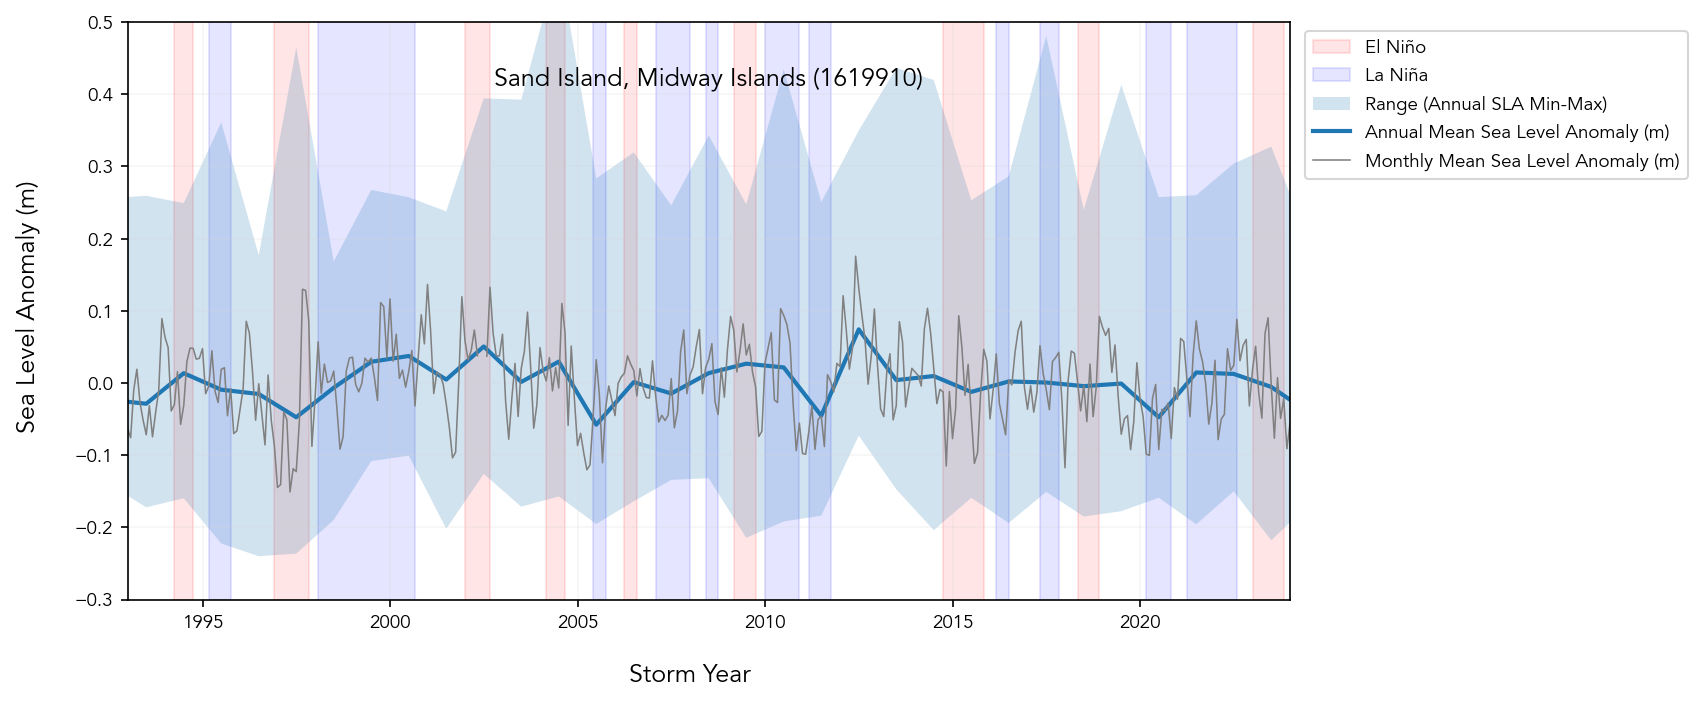

In [21]:
fig,ax = plt.subplots(figsize=(10,5))
# add ENSO to the plots
# import oni.csv
oni = pd.read_csv(data_dir/'climate_indices/oni_bool.csv',header=0)
# change oni index to Date column
oni.index = pd.to_datetime(oni['time'] )
#adjust the index to be float value of fractional year
oni.index = oni.index.year + (oni.index.month - 1)/12 - 5/12

sid = 1
plot_TG_rsl_anomaly_annual(sid, fig, ax,  rsl_yearly_mean, rsl_subset, rsl_anomalies,oni,oniPlot=True)
ax.legend(loc='upper right', ncol=1, bbox_to_anchor=(1.35, 1.0))

# Save the plot to a file
filename = '1.2_SL_MMA_annual_' + str(rsl_yearly_mean['station_name'].isel(station_id=sid).values) + '.png'
plt.savefig(output_dir / filename, dpi=300, bbox_inches='tight')

fig.text(0.05, 0.5, 'Sea Level Anomaly (m)', va='center', rotation='vertical')
fig.text(0.5, 0, 'Storm Year', ha='center')

glue('SL_MMA_annual_station',fig,display=False)
station = str(rsl_yearly_mean['station_name'].isel(station_id=sid).values)

glue('station',station,display=False)

```{glue:figure} SL_MMA_annual_station
:name: "SL_MMA_annual_station"

Yearly mean anomalies at the {glue:text}`station` tide gauge with background trend removed (blue). The shaded region about the annual mean denotes the annual means of the daily min and max sea level. Note that the sea level is plotted in units of m. The monthly mean anomaly (gray) is calculated with respect to the annual cycle. El Niño and La Niño time periods are derived from the Oceanic Niño Index (ONI), available at https://origin.cpc.ncep.noaa.gov/products/analysis_monitoring/ensostuff/ONI_v5.php  
```

### Create a time series plot
Now we will plot all the gauges.

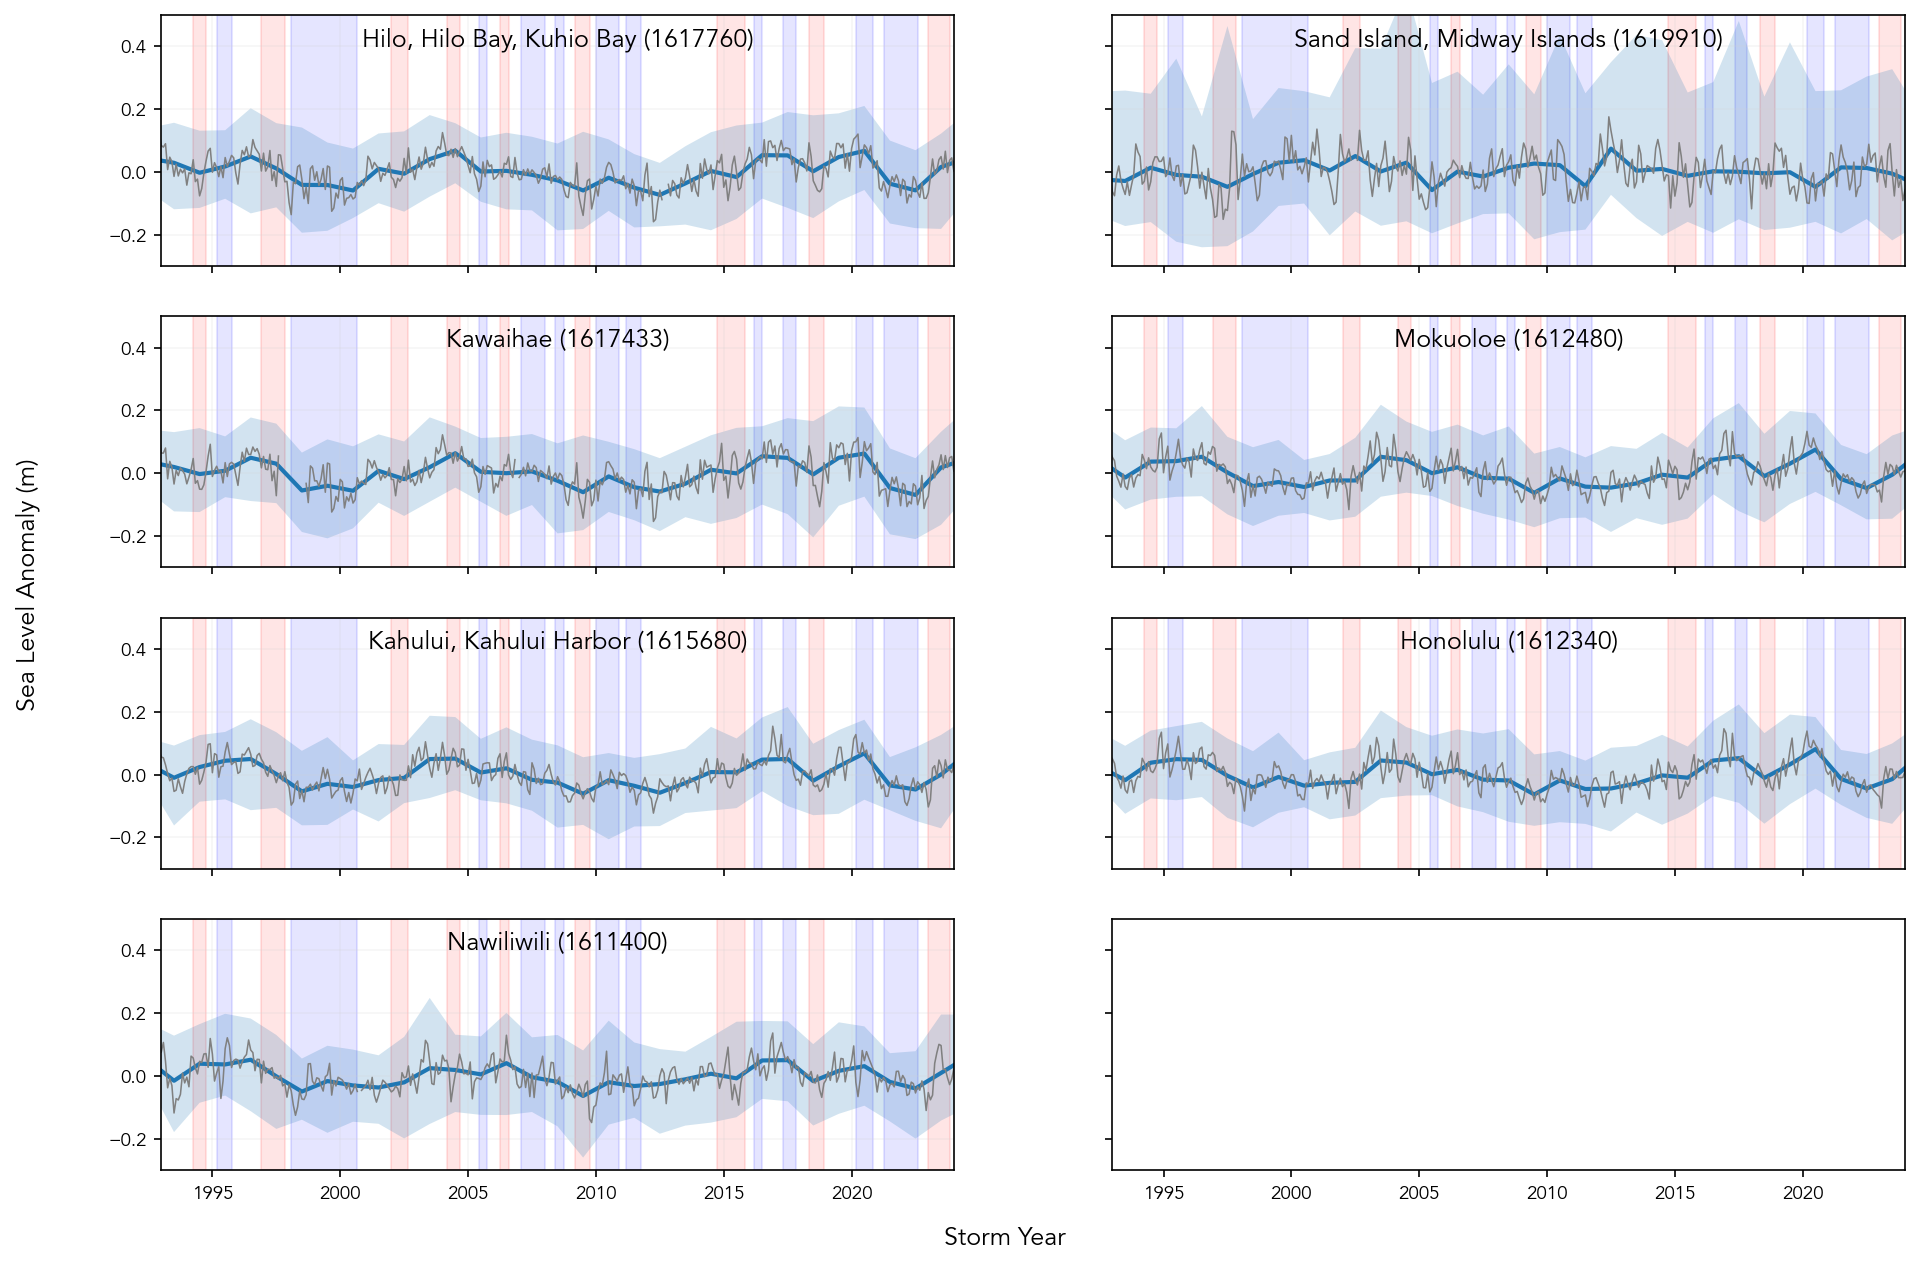

In [22]:
# get axis for the plots
fig,axes = plt.subplots(4,2,figsize=(15,10), sharex=True, sharey=True)
axes = axes.flatten()



station_ids = rsl_monthly.station_id.values
# iterate over each axis and plot the monthly mean
for i in range(len(station_ids)):
    ax = axes[i]
    plot_TG_rsl_anomaly_annual(i, fig, ax,  rsl_yearly_mean, rsl_subset, rsl_anomalies,oni,oniPlot=True)

    if i < 7:
        ax.set_xlabel('')    


#add El Nino and La Nina years


# axes[7].legend(loc='lower center', ncol=3,bbox_to_anchor=(-0.1, -1),fontsize=12)

# add y label
fig.text(0.06, 0.5, 'Sea Level Anomaly (m)', va='center', rotation='vertical')
fig.text(0.5, 0.06, 'Storm Year', ha='center')


# Save the plot to a file
plt.savefig(output_dir / '1.2_SL_MMA_annual.png', dpi=300, bbox_inches='tight')

glue("SL_MMA_annual",fig,display=False)



```{glue:figure} SL_MMA_annual
:name: "SL_MMA_annual"

Yearly mean anomalies at the each tide gauge with background trend removed (blue). The blue shaded region denotes the yearly means of the daily min and max sea level anomalies. Note that the sea level is plotted in units of m, with the epoch daily mean and trend removed. The monthly mean anomaly (gray) is calculated with respect to the annual cycle. 
```

In [23]:
# finally, close the dask client
client.close()